# Clustering Algorithms

In this notebook, we will apply the following clustering algorithms to the Mall Customer Segmentation dataset:

1. K-Means: A popular partition-based clustering algorithm that minimizes the within-cluster sum of squares.
2. DBSCAN: A density-based clustering algorithm that groups points based on their proximity and density.
3. Agglomerative Clustering: A hierarchical clustering algorithm that builds nested clusters by merging or splitting them.

We will analyze the results of each clustering method and compare their performance.

## Executive Summary: 
Customers are segmented into 5 groups:
* **High Income/Low Spender (20%)**
    * Low conversion, target marketing for High End goods, quality service
* **High Income/High Spender(20%)**
    * Keep engagement high with low frequency marketing, add high end stores. 
* **Low Income/High Spender(10%)**
    * Likely high credit baring group. Possibly market line of credit
* **Low Income/Low Spender(10%)**
    * Provide high value and low cost price. Market to this group with specials and savings opportunities.
* **Average Income/Spender(40%)**
    * This is the highest cohort, so biggest potential income gain. Add additional value in the mall to increase expenditure. Research which stores will appeal to this group, add services.

## Mall Customer Segmentation Dataset

This dataset consists of mall customers' information, which can be used to gain insights into customers' behaviors and preferences. The dataset is available on [Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python).

The dataset has the following columns:

1. CustomerID: Unique ID assigned to the customer.
2. Gender: The gender of the customer (Male or Female).
3. Age: The age of the customer in years.
4. Annual Income (k$): The customer's annual income in thousands of dollars.
5. Spending Score (1-100): A score based on customer behavior and spending nature, ranging from 1 to 100.

We will apply clustering algorithms to this dataset to identify potential customer segments.


In [90]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
# Load the dataset
data = pd.read_csv('Mall_Customers.csv')

# Display the first few rows of the dataset
data.drop('CustomerID',axis=1)
warnings.filterwarnings(action='once')

## EDA

<Axes: xlabel='Gender', ylabel='Percent'>

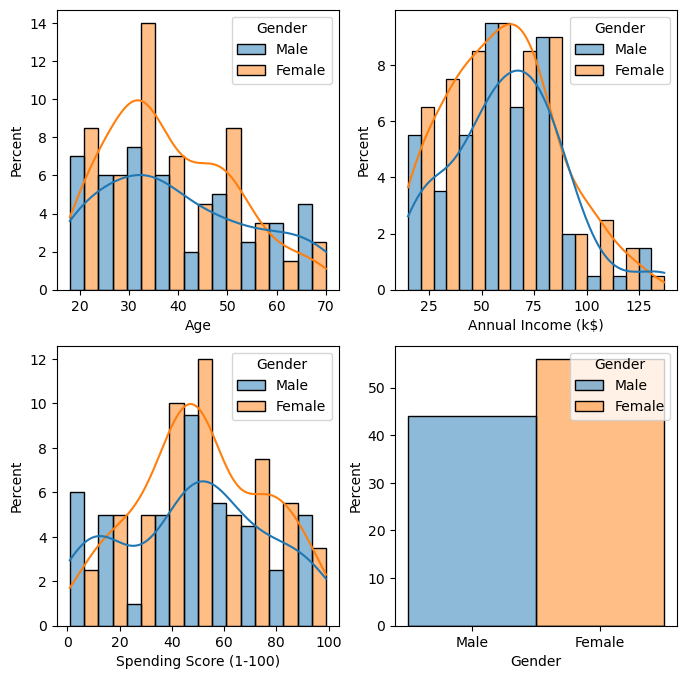

In [71]:
fig, axes = plt.subplots(ncols=2,nrows=2, figsize=(8,8))

sns.histplot(data=data, x ="Age",kde=True,ax=axes[0][0],stat="percent",hue="Gender",multiple="dodge")
sns.histplot(data=data, x ="Annual Income (k$)",kde=True,ax=axes[0][1],stat="percent",hue="Gender",multiple="dodge")
sns.histplot(data=data, x ="Spending Score (1-100)",kde=True,ax=axes[1][0],stat="percent",hue="Gender",multiple="dodge")
sns.histplot(data=data, x ="Gender",ax=axes[1][1],hue="Gender",stat="percent")

## Data Preparation

In [74]:
from sklearn.preprocessing import LabelEncoder

# Encode the categorical data, worked worse than Get_dummies
#le = LabelEncoder()
#data['Gender'] = le.fit_transform(data['Gender'])

#Technically I am introducing a bias by having two gender columns, when 1 would do, Sil with one Gender Col = 0.35
df_temp = data
df_temp = pd.get_dummies(df_temp, columns = ['Gender'], prefix = ['Gender'])
features = df_temp[['Age','Annual Income (k$)','Gender_Female','Gender_Male','Spending Score (1-100)']]
# Display the first few rows of the dataset after encoding
features.head()

,Age,Annual Income (k$),Gender_Female,Gender_Male,Spending Score (1-100)
0,19,15,0,1,39
1,21,15,0,1,81
2,20,16,1,0,6
3,23,16,1,0,77
4,31,17,1,0,40


In [59]:
Young = int(data[data["Age"]<30].count()[0]/len(data)*100)
Mid = int(data[(data["Age"]>30)&(data["Age"]<50)].count()[0]/len(data)*100)
Old = int(data[data["Age"]<30].count()[0]/len(data)*100)
               
Young_F = int(data[(data["Age"]<30)&(data["Gender"]==0)].count()[0]/data[data["Age"]<30].count()[0]*100)
Mid_F = int(data[(data["Age"]>=30)&(data["Age"]<=50)&(data["Gender"]==0)].count()[0]/data[(data["Age"]>30)&(data["Age"]<50)].count()[0]*100)
Old_F = int(data[(data["Age"]>50)&(data["Gender"]==0)].count()[0]/data[data["Age"]>50].count()[0]*100)

print(f"{Young} % young customers of which {Young_F} % are Female") #Young
print(f"{Mid} % middle aged customers {Mid_F} % are Female") #Young
print(f"{Old} % older customers {Old_F} % are Female") #Young

27 % young customers of which 52 % are Female
46 % middle aged customers 69 % are Female
27 % older customers 45 % are Female


Results: 
* 10% more Females on average visit the mall compared to Males.
* 46% of all customers are Middle Aged, and are also 70% Female.
* Female customers who visit the mall also appear to have higher income and slightly higher spend compared to Males.

## Data Segmentation
### KNN Clustering: optimising K

C:\Users\Spook\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Spook\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Spook\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Spook\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

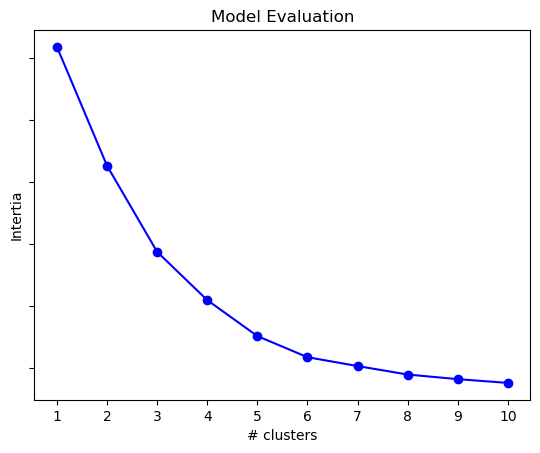

In [75]:
# Scale the data 
# Data Scaling worsens the clustering significantly, Sil = 0.30, so removed...
#scaler = StandardScaler()
#scaled_data = scaler.fit_transform(features)

inertia = []
#Run Kmeans for K = 1-20
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10)
    kmeans.fit(features)
    
    inertia.append(kmeans.inertia_)

#Plot results from clustering
plt.plot(range(1, 11), inertia,'bo-')
plt.title('Model Evaluation')
plt.xlabel('# clusters')
plt.ylabel('Intertia')
ax = plt.gca()
ax.yaxis.set_tick_params(labelleft=False)
plt.xticks(np.arange(1, 11, 1.0))
plt.show()

Elbow at K = 6

### KMeans: optimising K

C:\Users\Spook\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Spook\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Spook\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Spook\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

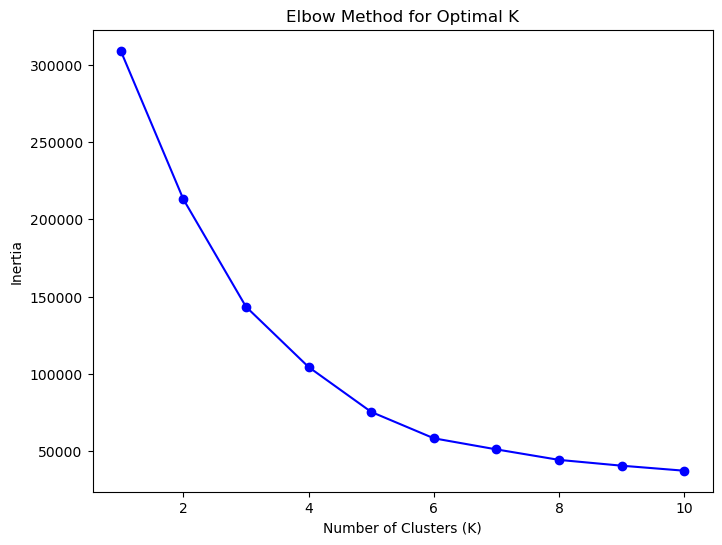

In [77]:
warnings.filterwarnings(action='once')

# Calculate the inertia for different values of K
inertia_values = []
K_values = list(range(1, 11))

for k in K_values:
    kmeans_model = KMeans(n_clusters=k,n_init=10)
    kmeans_model.fit(features)
    inertia_values.append(kmeans_model.inertia_)

# Plot the elbow method
plt.figure(figsize=(8, 6))
plt.plot(K_values, inertia_values, 'bo-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

Elbow at K = 6

### Running models: KNN, KMeans, DBSCAN, Agglomerative Clustering

In [91]:
# Set the BestK variables
BestKmeansK = 6
BestKNN_K = 6

# Define the clustering algorithms
clustering_algorithms = {
    'KNN': KMeans(n_clusters = BestKNN_K, init = 'k-means++', max_iter = 300, n_init = 10, random_state=1),
    'K-Means': KMeans(n_clusters=BestKmeansK, random_state=1),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
    'Agglomerative Clustering': AgglomerativeClustering(n_clusters=BestKNN_K)
}

# Apply the clustering algorithms and store the results
results = {}
for name, algorithm in clustering_algorithms.items():
    algorithm.fit(features)
    labels = algorithm.labels_
    
    # Calculate the silhouette score for each algorithm
    if len(np.unique(labels)) > 1:
        silhouette = silhouette_score(features, labels)
    else:
        silhouette = np.nan
        
    results[name] = {
        'Labels': labels,
        'Silhouette Score': silhouette
    }

# Compare the results in a DataFrame
results_df = pd.DataFrame(results).T
results_df

C:\Users\Spook\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Spook\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Spook\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



,Labels,Silhouette Score
KNN,"[4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, ...",0.451768
K-Means,"[4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, ...",0.451768
DBSCAN,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",NaN
Agglomerative Clustering,"[4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, ...",0.442516


KNN and Kmeans perform equally. Visualising may show better performance
### Plotting

In [92]:
data['Cluster']= results['KNN']['Labels']

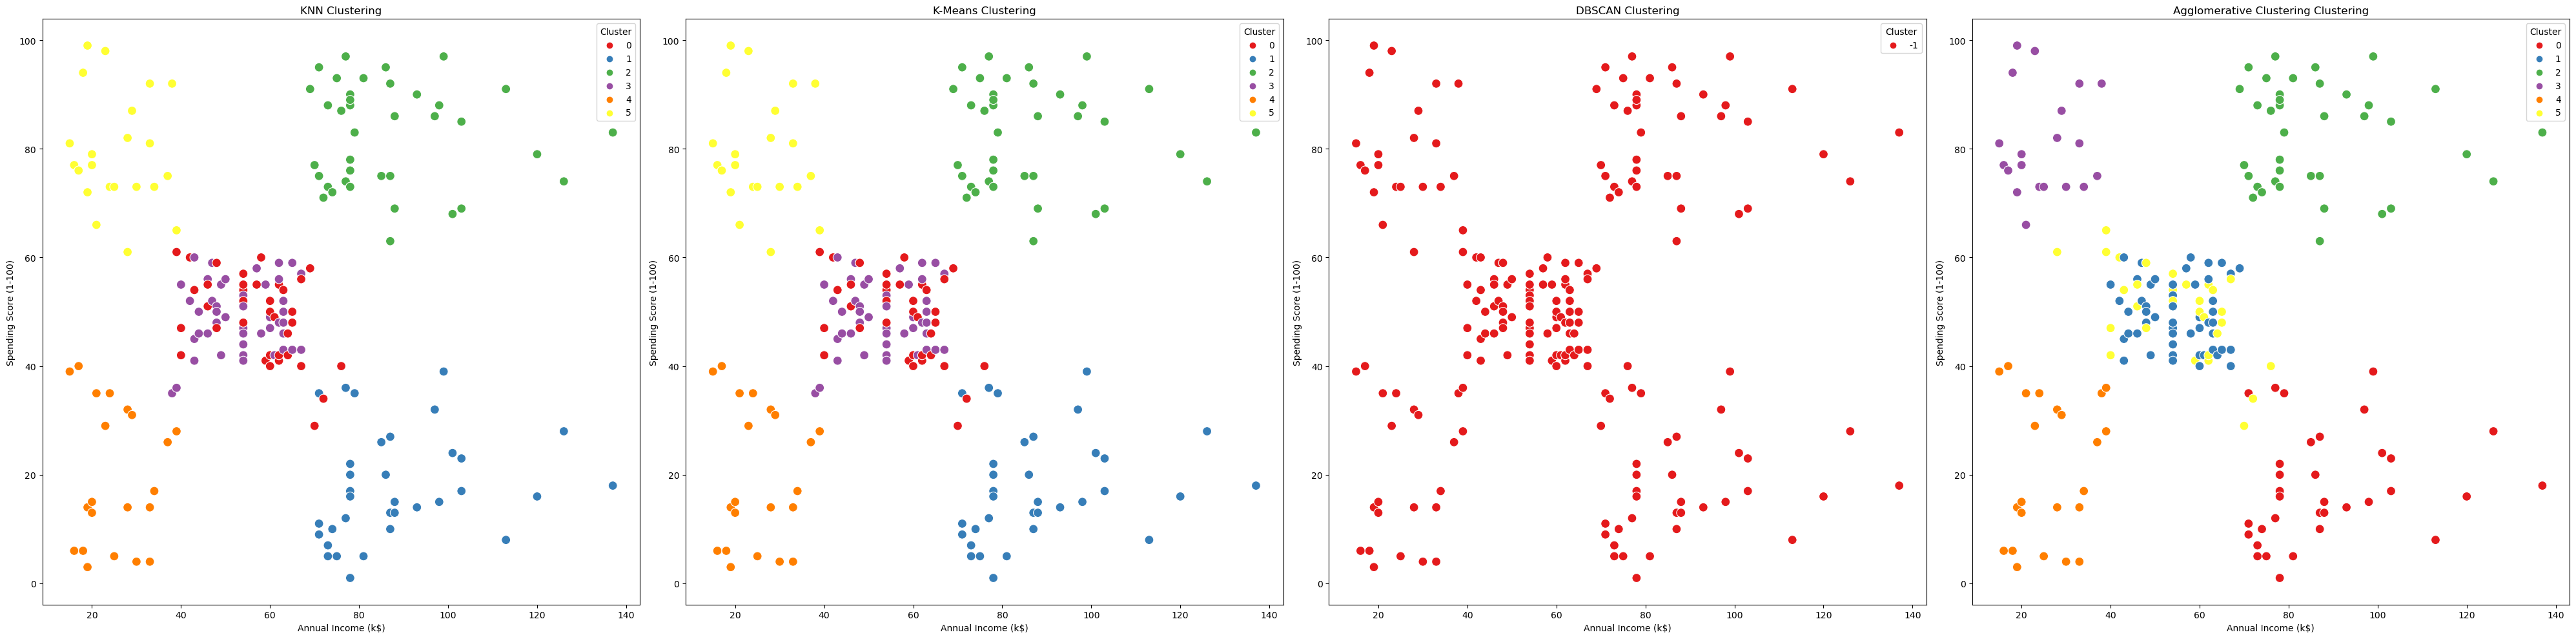

In [93]:
# Set up the 3x1 grid for the plots
fig, axes = plt.subplots(1, 4, figsize=(40, 10))

# Choose the two most relevant features for visualization
x_axis = 'Annual Income (k$)'
y_axis = 'Spending Score (1-100)'

for index, (name, result) in enumerate(results.items()):
    # Plot the clusters using different colors
    sns.scatterplot(data=data, x=x_axis, y=y_axis, hue=results[name]['Labels'], palette='Set1', ax=axes[index], s=100)
    
    # Set the title and labels for each plot
    axes[index].set_title(f"{name} Clustering")
    axes[index].set_xlabel(x_axis)
    axes[index].set_ylabel(y_axis)
    axes[index].legend(title='Cluster', loc='upper right')

# Display the plots
plt.tight_layout()
plt.show()

KMeans and KNN similar, choosing KNN. Cluster in the middle seems strange, but may be clustered in Alt direction. Aggl finds similar clusters. This is more evidence that the clusters are representative. 

What about the other variables?

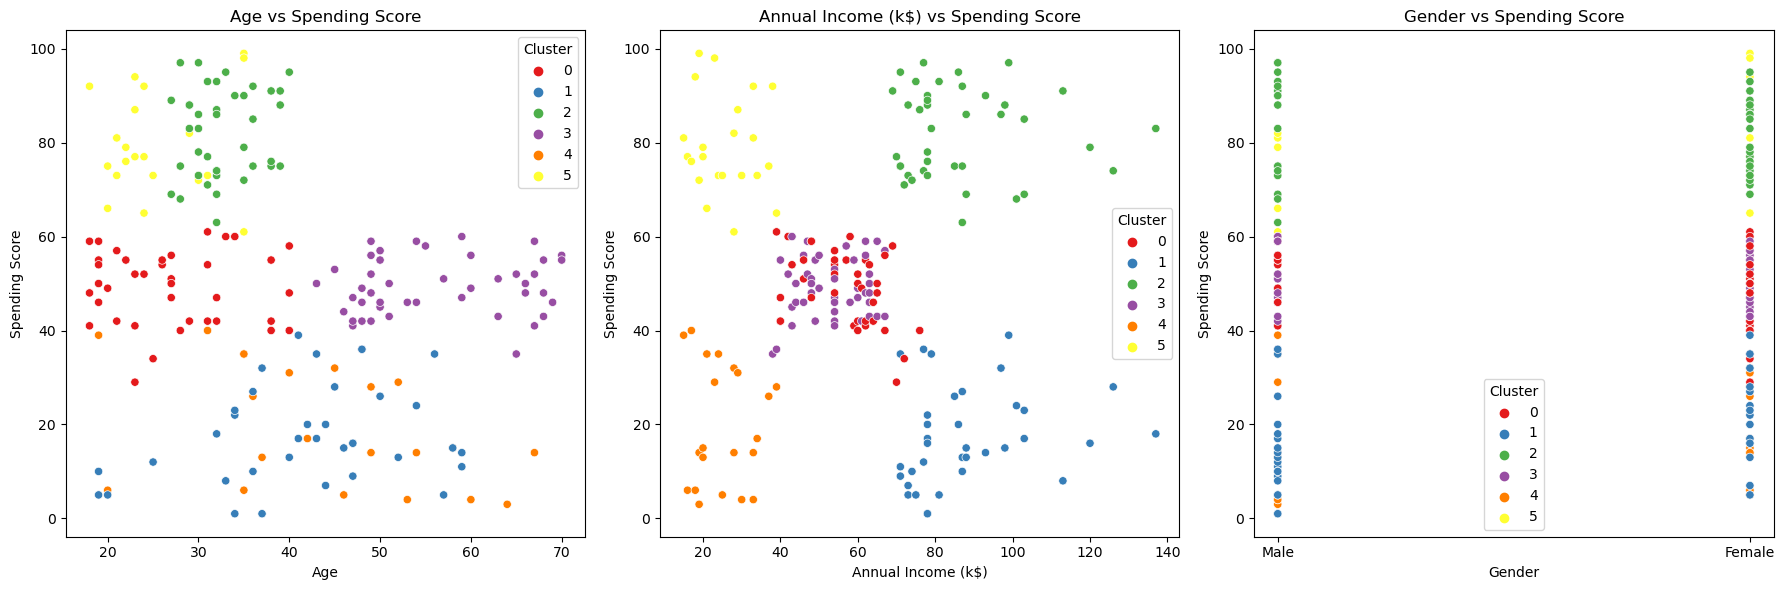

In [81]:
import matplotlib.pyplot as plt

# Assuming best_model is the clustering model you have chosen
#best_model.fit(scaled_data)
#labels = best_model.labels_

# Add the cluster labels to the original DataFrame

# List of variables to plot against the spending score
variables = ['Age', 'Annual Income (k$)', 'Gender']  # Replace these with the actual variable names

# Create a scatter plot for each variable in a 1x3 grid
fig, axes = plt.subplots(1, len(variables), figsize=(6 * len(variables), 6))

for index, variable in enumerate(variables):
    sns.scatterplot(data=data, x=variable, y='Spending Score (1-100)', hue='Cluster', palette='Set1', ax=axes[index])
    axes[index].set_title(f"{variable} vs Spending Score")
    axes[index].set_xlabel(variable)
    axes[index].set_ylabel("Spending Score")

plt.tight_layout()
plt.show()


Segmented well in Age and Income, gender is difficult. 3D gives best representation

C:\Users\Spook\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



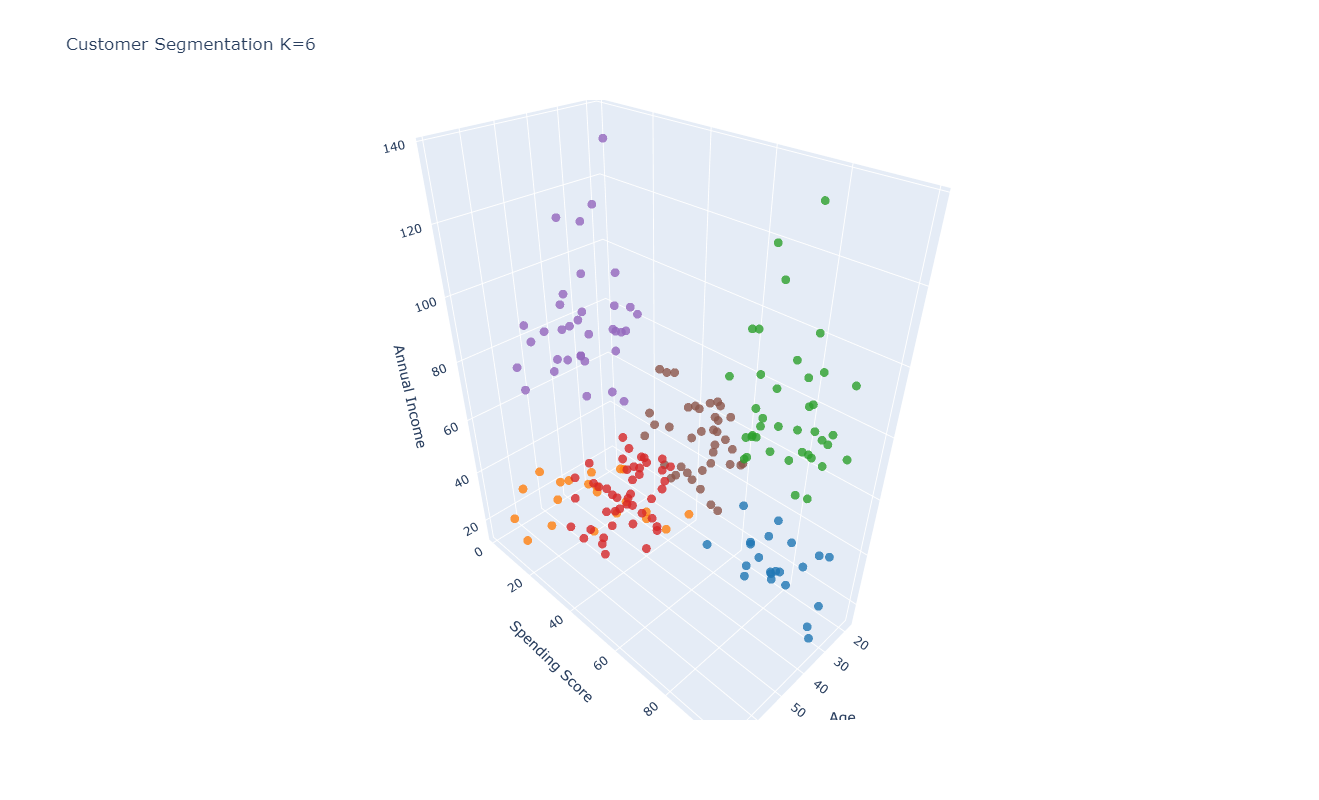

In [95]:
#Use Plotly to plot 3D of clusters to show Ave has two subcategories
import plotly as py
import plotly.graph_objs as go

#Map the clusters to fi labels. May change when run
data['group'] = data['Cluster'].map({0:"HI/LS",
                                 1:'HI/HS',
                                 2:"Ave(Old)",
                                 3:"Ave(Yng)",
                                 4:'LI/HS',
                                 5:"LI/LS"})
#Map colors from matplotlib Tab:colors to labels
data['colors']=data['group'].map({'Ave(Old)':"#2ca02c",
                            "HI/LS":"#8c564b",
                            "HI/HS":"#9467bd",
                            "LI/LS":"#1f77b4",
                            "LI/HS":"#ff7f0e",
                            'Ave(Yng)':"#d62728"})
trace1 = go.Scatter3d(
    x= data['Age'],
    y= data['Spending Score (1-100)'],
    z= data['Annual Income (k$)'],
    mode='markers',
     marker=dict(
         cmin=0,
         cmax=4,
        color=data['colors'],
        size= 5,
        opacity=0.8
     )
)
dataplot = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
    title= f'Customer Segmentation K={BestKNN_K}',
    width=800,  # Set the width of the figure (in pixels)
    height=800,  # Set the height of the figure (in pixels)
    scene = dict(
            xaxis = dict(title  = 'Age'),
            yaxis = dict(title  = 'Spending Score'),
            zaxis = dict(title  = 'Annual Income')
        )
)
fig = go.Figure(data=dataplot, layout=layout)
py.offline.iplot(fig)

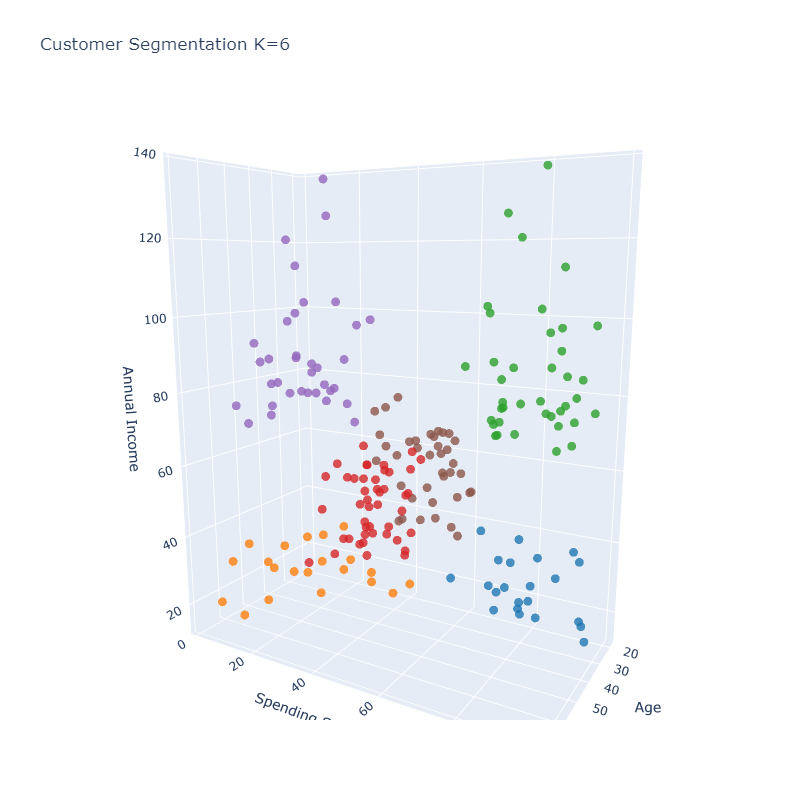

In [85]:
#Displaying plotly 3D plot for Github
from IPython.display import Image
Image(filename='3Dplot.png') 

In [89]:
#Calculate various ages
max_spender = data[(data["Spending Score (1-100)"]>60)]["Age"].max()
print(f"The maximum age of high spenders (Score>60) is {max_spender} years.")
meanLI_LS_age = int(data[data["group"]=="LI/HS"]['Age'].mean())
meanLI_HS_age = int(data[data["group"]=="LI/LS"]['Age'].mean())
print(f"Ave Age of LI/HS is {meanLI_HS_age} years")
print(f"Ave Age of LI/LS is {meanLI_LS_age} years")

meanHI_HS_age = int(data[data["group"]=="HI/HS"]['Age'].mean())
meanHI_LS_age = int(data[data["group"]=="HI/LS"]['Age'].mean())
print(f"Ave Age of HI/HS is {meanHI_HS_age} years")
print(f"Ave Age of HI/LS is {meanHI_LS_age} years")

The maximum age of high spenders (Score>60) is 40 years.
Ave Age of LI/HS is 25 years
Ave Age of LI/LS is 44 years
Ave Age of HI/HS is 41 years
Ave Age of HI/LS is 27 years


### Discussion/Conclusions: 

Customers can be categorised based on 6 clusters:
* **High Income/Low Spender (20%)**
    * Average age between 40-60
    * Low conversion, target marketing for High End goods, quality service for older brands.
* **High Income/High Spender(20%)**
    * High Income young group.
    * Keep engagement high with low frequency marketing, add high end young brands.
* **Low Income/High Spender(10%)**
    * Mostly Young (Age between 20-30)
    * Likely high credit baring group. Possibly market line of credit, market younger cheap brands.
* **Low Income/Low Spender(10%)**
    * Frugal group with wide age spread
    * Provide high value and low cost price. Market to this group with specials and savings opportunities.
    * Likely low credit baring group. Possibly market cheap line of credit.
* **Young Average Income/Spender(20%)**
    * This is the largest age combined cohort, so biggest potential income gain. Add additional value in the mall to increase expenditure. Research which stores will appeal to this group, add services. Add younger brands to convert more sales from this group.
* **Older Average Income/Spender(20%)**
    * This is the largest cohort, so biggest potential income gain. Add additional value in the mall to increase expenditure. Research which stores will appeal to this group, add services.Add older brands to convert more sales from this group.
    